# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import re

# Natural Langauge Toolkit
from nltk.corpus import stopwords
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import sys
import os
import re
from sqlalchemy import create_engine
import pickle

from scipy.stats import gmean
# import relevant modules from the sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# install imbalanced-learn for transforming minority class and mitigate label imbalance.
# ! pip install imbalanced-learn
# ! pip install numpy==1.8

    100% |████████████████████████████████| 215kB 8.1MB/s ta 0:00:01   14% |████▊                           | 30kB 11.3MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.3MB/s eta 0:00:01   25% |████████▏                       | 3.4MB 19.4MB/s eta 0:00:01    32% |██████████▌                     | 4.4MB 17.9MB/s eta 0:00:01    40% |████████████▉                   | 5.4MB 18.3MB/s eta 0:00:01    86% |███████████████████████████▊    | 11.6MB 19.9MB/s eta 0:00:01    94% |██████████████████████████████▍ | 12.7MB 21.7MB/s eta 0:00:01
    100% |████████████████████████████████| 20.0MB 1.7MB/s eta 0:00:01 0% |▏                               | 92kB 10.6MB/s eta 0:00:02    30% |██████████                      | 6.2MB 21.2MB/s eta 0:00:01    36% |███████████▋                    | 7.2MB 21.7MB/s eta 0:00:01    46% |██████████████▉                 | 9.3MB 23.3MB/s eta 0:00:01    51% |████████████████▋               | 10.3MB 22.2MB/s eta 0:00:01    57% |██████████████████▎        

In [5]:
# load data from database
engine = create_engine('sqlite:///final_response.db')
df = pd.read_sql_table('final_responsetable', 'sqlite:///final_response.db')  

In [6]:
df.describe() #not from the describe, child_alone has a whole column of zero, we should be able to just drop this.

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From above and also below, only the 'related' may have a mistake, i.e. 0, 1, 2

In [7]:
# df['related'].value_counts()
df.groupby('related').count() # when using goupby, follow up with some metric, in this case count but could be mean - for example.

,id,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,6122,6122,3395,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1.0,19906,19906,6643,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906
2.0,188,188,132,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188


In [8]:
def replace_with_majority(row):
    # import pdb; pdb.set_trace()
    if row == 2.0:
        return 1.0
    return row

df['related'] = df['related'].apply(replace_with_majority)
df['related'].value_counts() # great, we've gotten rid of the 2.0 which was most probably an error.

1.0    20094
0.0     6122
Name: related, dtype: int64

## Remove Class with only 0.0 (child_alone)
If this class is not removed, will run into the error below:
**valueerror: this solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0**

In [9]:
df.drop(['child_alone'], axis=1, inplace=True)

In [10]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# ------------------------------------
X = df['message']
y = df.iloc[:,4:]
# ------------------------------------
features = df['message']
labels = df.iloc[:,4:] # take from 4 col, i.e. 'id', 'origignal', 'message', and 'genre' cols do not have any value and not labels.
# features # note, we can do some clearning here.
X.shape, y.shape

((26216,), (26216, 35))

In [11]:
#----------------------------------------------------------------------------

In [12]:
# custom function for you to visualize all the cleaning of the text.
def normalize_clean(text):
    text = text.lower() # normalize
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) # remove punctuations
    text = re.sub(r'http\S+', '', text) # remove urls
    text = re.sub(r'[%$#]', '', text) # remove special chars
    text = re.sub("[^a-zA-Z]", " ", text) # clean numbers 
    return text

features = features.apply(normalize_clean)
features

0        weather update   a cold front from cuba that c...
1                  is the hurricane over or is it not over
2                          looking for someone but no name
3        un reports leogane       destroyed  only hospi...
4        says  west side of haiti  rest of the country ...
5                   information about the national palace 
6                           storm at sacred heart of jesus
7        please  we need tents and water  we are in sil...
8          i would like to receive the messages  thank you
9        i am in croix des bouquets  we have health iss...
10       there s nothing to eat and water  we starving ...
11       i am in petionville  i need more information r...
12       i am in thomassin number     in the area named...
13       let s do it together  need food in delma     i...
14       more information on the      number in order f...
15       a comitee in delmas     rue   street   janvier...
16       we need food and water in klecin     we are dy.

Next we will remove stop words:
Stop words usually refers to the most commonly used words in a language (such as “the”, “a”, “an”, “in”)
This step is a one of the important steps to come up with more robust input. We will do all this in the tockenize def.

### 2. Write a tokenization function to process your text data

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize_custom(text):    
    # Extract the word tokens from the provided text row 
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w in stop_words] #stopwords removal
    
    #Lemmanitizer to remove inflectional and derivationally related forms of a word
    lemmatizer = nltk.WordNetLemmatizer()
    cleaned_tokens = [lemmatizer.lemmatize(w).strip() for w in tokens]
    
    return cleaned_tokens

features = features.apply(tokenize_custom)
features

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0        [weather, update, cold, front, cuba, could, pa...
1                                              [hurricane]
2                                 [looking, someone, name]
3        [un, report, leogane, destroyed, hospital, st,...
4        [say, west, side, haiti, rest, country, today,...
5                          [information, national, palace]
6                            [storm, sacred, heart, jesus]
7                 [please, need, tent, water, silo, thank]
8                   [would, like, receive, message, thank]
9        [croix, de, bouquet, health, issue, worker, sa...
10                [nothing, eat, water, starving, thirsty]
11             [petionville, need, information, regarding]
12       [thomassin, number, area, named, pyron, would,...
13        [let, together, need, food, delma, didine, area]
14       [information, number, order, participate, see,...
15       [comitee, delmas, rue, street, janvier, impass...
16       [need, food, water, klecin, dying, hunger, imp.

In [12]:
def tokenize(text):    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


## Summary of text preprocessing
* Normalize - to lowercase and cleaned up punctuation
* tokenize - to each individual word
* removal of stop words - reduce the dimensionality we are working with.
* stemming/lemmetization - to further reduce words we work with.

In [13]:
# from lecture - here is a custom transformer for us to include in our pipeline
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence)) # using our defined token() above after pos.
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
# We will try various models and use GridSearchCV to get the est hyperparameters for each model.
models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(verbose=True),
            "hyperparameters":
                {
                    "classifier__estimator__solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "AdaBoostClassifier",
            "estimator": AdaBoostClassifier(),
            "hyperparameters":
                {
                    'classifier__estimator__learning_rate': [0.01, 0.02, 0.05],
                    'classifier__estimator__n_estimators': [10, 20, 40]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1, verbose=True),
            "hyperparameters":
                {
                    "classifier__estimator__n_estimators": [20],
                    "classifier__estimator__criterion": ["entropy", "gini"],
                    "classifier__estimator__max_depth": [2, 5, 10],
                    "classifier__estimator__max_features": ["log2", "sqrt"],
                    "classifier__estimator__max_features": [1, 5, 8],
                    "classifier__estimator__min_samples_split": [2, 3, 5]

                }
        }
    ]

In [11]:
# from instructions above, suggesting for us to use MultiOuptuClassifier
# strategy based on fitting one classifier per target.

def build_model(models, tune_hyperparameters=False):
    pipes, grids = [], []
    # create a pipeline + GridSearch obj for each model.
    for model in models:
        # import pdb; pdb.set_trace()
        pipeline = Pipeline([
            ('features', FeatureUnion([

                ('text_pipeline', Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()) # adding addtional features.
                ])),

                ('starting_verb', StartingVerbExtractor())
            ])),

            ('classifier', MultiOutputClassifier(model['estimator']))
        ])
        # --------------------------------------------
        # Hyperameter tuning
        # --------------------------------------------
        cv = GridSearchCV(pipeline, param_grid=model['hyperparameters'], scoring='f1_micro', n_jobs=-1)
        grids.append(cv)
        pipes.append(pipeline)
    return grids if tune_hyperparameters else pipes

def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

From above, we have CountVectorizer and tfidf running in parallel.
* convert to float/int for model to digest
* add additional features, i.e. tfidf transformation.

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [67]:
# verifying imbalance
for i, col in enumerate(y.columns):
    minority = y[col].value_counts().values
    min_perc = minority[1] / sum(minority)
    print("="*10, f"{minority[0], minority[1]} {col}: {min_perc}", "="*10)

========== (20094, 6122) related: 0.23352151357949344 ==========
========== (21742, 4474) request: 0.17065913945682026 ==========
========== (26098, 118) offer: 0.0045010680500457735 ==========
========== (15356, 10860) aid_related: 0.4142508391821788 ==========
========== (24132, 2084) medical_help: 0.0794934391211474 ==========
========== (24903, 1313) medical_products: 0.05008391821788221 ==========
========== (25492, 724) search_and_rescue: 0.027616722612145254 ==========
========== (25745, 471) security: 0.017966127555691182 ==========
========== (25356, 860) military: 0.03280439426304547 ==========
========== (24544, 1672) water: 0.0637778455904791 ==========
========== (23293, 2923) food: 0.11149679584986268 ==========
========== (23902, 2314) shelter: 0.08826670735428746 ==========
========== (25811, 405) clothing: 0.0154485810192249 ==========
========== (25612, 604) money: 0.023039365273115654 ==========
========== (25918, 298) missing_people: 0.011367104058590174 ==========


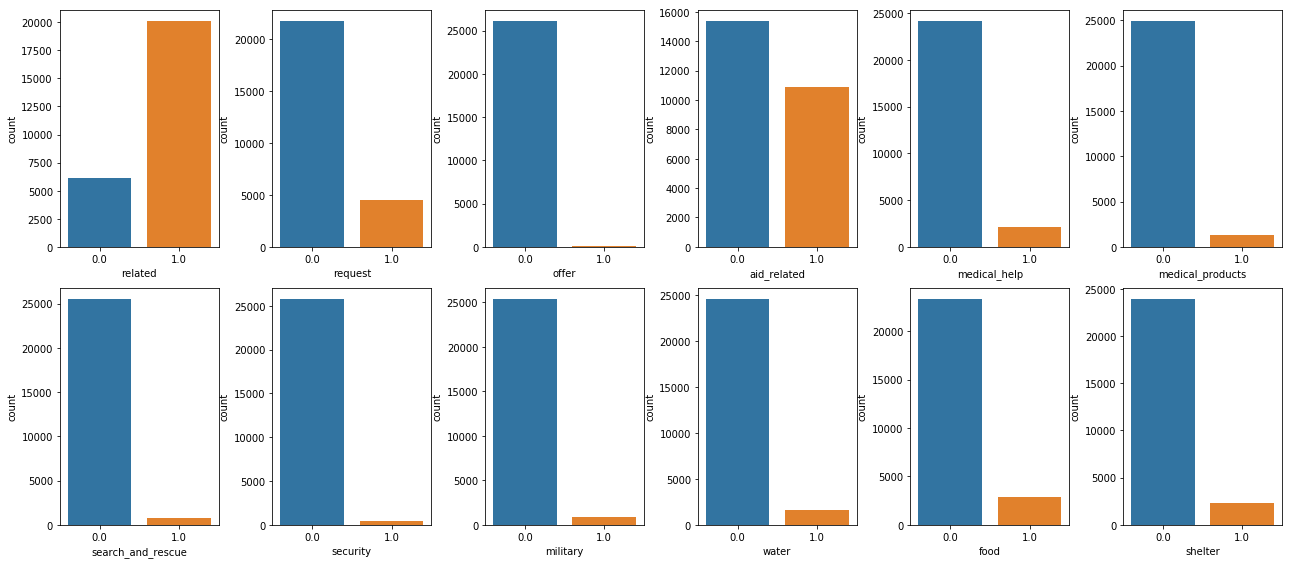

(26216, 35)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
labels = df.columns[4:]
# just plotting two rows to see imbalance.
rows, cols = 2,6
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18,8))
fig.tight_layout(pad=2)
i = 0
for row in range(rows):
    for col in range(cols):
        sns.countplot(x=y[labels[i]] , data=y, ax=axes[row][col])
        i += 1
plt.show()
y.shape

In [50]:
!pip install imblearn

  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.8.0
    Uninstalling numpy-1.8.0:
      Successfully uninstalled numpy-1.8.0


In [41]:
from sklearn.utils import resample
df_upsampled = y
for i, col in enumerate(y.columns):
    print(f"Before upsample: {df_upsampled.shape}")
    # the use of value_counts() will randomly rotate the keys use to_dict instead.
    label = y[col].value_counts().to_dict() 
    zeros, ones = label[0.0], label[1.0]
    if zeros < ones:
        df_minority = y[y[col] == 0.0]
        df_majority = y[y[col] == 1.0]
        major = ones
    else:
        df_minority = y[y[col] == 1.0]
        df_majority = y[y[col] == 0.0]
        major = zeros
    df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=major,
                                    random_state=1)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    print(f"({i})completed minority upsample for: '{col}'")
    # print(df_upsampled[col].value_counts())
    print(f"After upsample: {df_upsampled.shape}")
    break

Before upsample: (26216, 35)
(0)completed minority upsample for: 'related'
After upsample: (40188, 35)


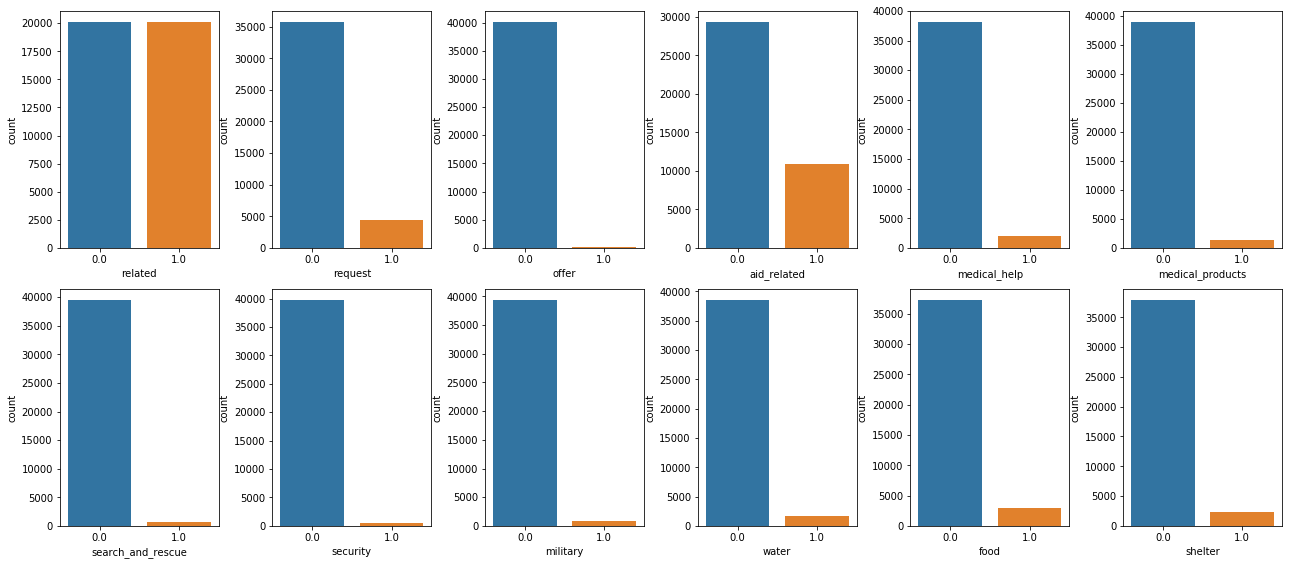

In [42]:
labels = df.columns[4:]
# just plotting two rows to see imbalance.
rows, cols = 2,6
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18,8))
fig.tight_layout(pad=2)
i = 0
for row in range(rows):
    for col in range(cols):
        sns.countplot(x=df_upsampled[labels[i]] , data=df_upsampled, ax=axes[row][col])
        i += 1
plt.show()

In [14]:
# fit all 3 candidate baseline models without hyperparameter tuning - establish baseline.
pipelines = build_model(models=models,
                       tune_hyperparameters=False) 
trained_models = {}
for pipe, model in zip(pipelines, models):
    # import pdb; pdb.set_trace()
    trained_models[model['name']] = pipe.fit(X_train, y_train)
    print("=" * 25, model['name'], "=" * 25)
    

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]========================= LogisticRegression =========================
========================= AdaBoostClassifier =========================


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]

========================= RandomForestClassifier =========================


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [15]:
len(trained_models) # 3 trained models

3

In [16]:
for k, v in trained_models.items():
    # testing accuracy
    y_test_pred = v.predict(X_test)
    y_train_pred = v.predict(X_train)
    print("=" * 25, f" Test set: {k}", "=" * 25)
    print(classification_report(y_test.values, y_test_pred, target_names=labels.columns.values))
    print("=" * 25, f" Train set: {k}", "=" * 25)
    print(classification_report(y_train.values, y_train_pred, target_names=labels.columns.values))

=========================  Test set: LogisticRegression =========================
                        precision    recall  f1-score   support

               related       0.83      0.96      0.89      6598
               request       0.84      0.56      0.67      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.76      0.67      0.71      3545
          medical_help       0.66      0.14      0.23       701
      medical_products       0.88      0.16      0.27       446
     search_and_rescue       1.00      0.03      0.05       226
              security       0.00      0.00      0.00       160
              military       0.56      0.05      0.10       267
                 water       0.78      0.45      0.57       543
                  food       0.86      0.57      0.68       965
               shelter       0.83      0.44      0.58       775
              clothing       0.76      0.10      0.18       127
                 mone

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


=========================  Test set: AdaBoostClassifier =========================
                        precision    recall  f1-score   support

               related       0.82      0.94      0.88      6598
               request       0.78      0.55      0.64      1472
                 offer       0.09      0.03      0.04        38
           aid_related       0.75      0.58      0.66      3545
          medical_help       0.57      0.26      0.36       701
      medical_products       0.63      0.30      0.41       446
     search_and_rescue       0.58      0.17      0.27       226
              security       0.12      0.02      0.03       160
              military       0.53      0.28      0.37       267
                 water       0.72      0.61      0.66       543
                  food       0.80      0.68      0.74       965
               shelter       0.76      0.57      0.65       775
              clothing       0.65      0.40      0.50       127
                 mone

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

=========================  Test set: RandomForestClassifier =========================
                        precision    recall  f1-score   support

               related       0.82      0.93      0.87      6598
               request       0.84      0.37      0.51      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.73      0.52      0.61      3545
          medical_help       0.63      0.05      0.10       701
      medical_products       0.67      0.09      0.15       446
     search_and_rescue       0.52      0.05      0.10       226
              security       0.00      0.00      0.00       160
              military       0.64      0.06      0.11       267
                 water       0.84      0.29      0.43       543
                  food       0.82      0.34      0.48       965
               shelter       0.83      0.17      0.28       775
              clothing       0.55      0.05      0.09       127
                 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


From the above we can clearly see that the f1-score on the testing sets for some categories are very low or even 0.0. This is becuase of the label/target mismatch.
* We will attempt to use SMOTE soon, to balance out the distribution of our labels.

### 6. Improve your model
Use grid search to find better parameters. 

In [14]:
models = [
#         {
#             "name": "LogisticRegression",
#             "estimator": LogisticRegression(verbose=True),
#             "hyperparameters":
#                 {
#                     "classifier__estimator__solver": ["newton-cg", "lbfgs", "liblinear"]
#                 }
#         },
        {
            "name": "AdaBoostClassifier",
            "estimator": AdaBoostClassifier(),
            "hyperparameters":
                {
                    'classifier__estimator__learning_rate': [0.01, 0.02, 0.05],
                    'classifier__estimator__n_estimators': [10, 20, 40]
                }
        },
#         {
#             "name": "RandomForestClassifier",
#             "estimator": RandomForestClassifier(random_state=1, verbose=True),
#             "hyperparameters":
#                 {
#                     "classifier__estimator__n_estimators": [20],
#                     "classifier__estimator__criterion": ["entropy", "gini"],
#                     "classifier__estimator__max_depth": [2, 5, 10],
#                     "classifier__estimator__max_features": ["log2", "sqrt"],
#                     "classifier__estimator__max_features": [1, 5, 8],
#                     "classifier__estimator__min_samples_split": [2, 3, 5]

#                 }
#         }
    ]

pipelines_grid = build_model(models=models, 
                        tune_hyperparameters=True)

trained_models_grid = {}
for pipe, model in zip(pipelines_grid, models):
    # import pdb; pdb.set_trace()
    trained_models_grid[model['name']] = pipe.fit(X_train, y_train)
    print("=" * 25, model['name'], "=" * 25)
    print("Completed GridSearch + fit !!!")
    print("=" * 25, model['name'], "=" * 25)

========================= AdaBoostClassifier =========================


In [17]:
for k, v in trained_models_grid.items():
    # testing accuracy
    # import pdb; pdb.set_trace()
    y_test_pred = v.predict(X_test)
    y_train_pred = v.predict(X_train)
    print("=" * 25, f" Test set: {k}", "=" * 25)
    print(v.best_params_)
    print(classification_report(y_test.values, y_test_pred, target_names=labels.columns.values))
    print("=" * 25, f" Train set: {k}", "=" * 25)
    print(classification_report(y_train.values, y_train_pred, target_names=labels.columns.values))

=========================  Test set: AdaBoostClassifier =========================
{'classifier__estimator__learning_rate': 0.01, 'classifier__estimator__n_estimators': 10}
                        precision    recall  f1-score   support

               related       0.76      1.00      0.87      6598
               request       0.59      0.38      0.46      1472
                 offer       0.00      0.00      0.00        38
           aid_related       0.81      0.19      0.31      3545
          medical_help       0.62      0.13      0.21       701
      medical_products       0.63      0.11      0.19       446
     search_and_rescue       0.65      0.20      0.31       226
              security       0.00      0.00      0.00       160
              military       0.00      0.00      0.00       267
                 water       0.56      0.84      0.68       543
                  food       0.78      0.68      0.73       965
               shelter       0.83      0.30      0.44      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [19]:
y_inf_train = pipeline_trained.predict(X_train)
y_inf_test = pipeline_trained.predict(X_test)

# Print classification report on test data
print(classification_report(y_test.values, y_inf_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.81      0.95      0.87      6598
               request       0.78      0.50      0.61      1472
                 offer       0.12      0.05      0.07        38
           aid_related       0.74      0.61      0.67      3545
          medical_help       0.57      0.25      0.35       701
      medical_products       0.60      0.30      0.40       446
     search_and_rescue       0.57      0.17      0.26       226
              security       0.17      0.03      0.04       160
              military       0.56      0.30      0.39       267
           child_alone       0.00      0.00      0.00         0
                 water       0.74      0.65      0.69       543
                  food       0.81      0.66      0.73       965
               shelter       0.76      0.53      0.63       775
              clothing       0.70      0.41      0.52       127
                 money       0.47      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.